In [ ]:

import requests
from bs4 import BeautifulSoup
from random import randint
from time import sleep
import pickle


# User-Agent Spoofing
user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"

headers = {'User-Agent': user_agent}


# Rate Limiting
def random_delay():
    sleep(randint(1, 4))  # Simulate human-like behavior

# Parse HTML
def parse_html(url):
    response = requests.get(url, headers=headers)
    return BeautifulSoup(response.content, 'html.parser')

# Pagination and Crawling
def crawl_pages(start_url,document_links):
    depth=100000000
    visited_urls = set()
    to_visit = [start_url]
    ix=0

    while to_visit and depth > 0:
        current_url = to_visit.pop(0)
        if current_url in visited_urls:
            continue
        print(' current_url: ',current_url, ' visited_urls: ',len(visited_urls), ' to_visit: ',len(to_visit), 'document_links: ', len(document_links) )
        
        if ('.pdf' in current_url )or ('doc' in current_url) or ('docx' in current_url) or ('ppt' in current_url) or( 'pptx' in current_url):
            document_links.append(current_url)
            with open('document_links.pkl', 'wb') as pickle_file:
                pickle.dump(document_links, pickle_file)
            continue
            
        
        soup = parse_html(current_url)
        visited_urls.add(current_url)
        depth -= 1

        # Extract data or perform actions here
        page_text = soup.get_text()
        save_to_file(current_url, page_text,ix)
        ix=ix+1

        # Find and add links to to_visit list
        links = [link.get('href') for link in soup.find_all('a', href=True)]
        for link in links:
            if link.startswith('/'):
                link = target_domain + link
            if link.startswith(target_domain) and link not in visited_urls:
                to_visit.append(link)

        random_delay() 

# Step 10: Data Extraction

# Save page text to a file
def save_to_file(url, content,ix):
    filename = url.replace('/', '_') +str(ix) +'.txt'
    filename = filename.replace('/', '_')
    filename = filename.replace(':', '_')
    filename = "text/" + domain + "/"+ filename
    #print(filename)
    with open(filename, 'w', encoding='utf-8') as file:
        file.write(content)

# Start crawling

target_domain = "http://example.com"
domain = 'example.com' 
document_links = []

crawl_pages(target_domain,document_links)
print(len(document_links))

In [3]:
import pandas as pd
import os
# Create a list to store the text files
texts=[]

# Get all the text files in the text directory
for file in os.listdir("text/" + domain + "/"):
    if file=='.DS_Store':
        continue
    # Open the file and read the text
    with open("text/" + domain + "/"+ file, "r", encoding="UTF-8") as f:
        text = f.read()
        texts.append((file[20:-4].replace('-',' ').replace('_', ' ').replace('#update',''), text))

# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['fname', 'text'])

df['text'] = df.fname + ". " + remove_newlines(df.text)


df.to_csv('processed/scraped.csv',escapechar='\\')
df.head()

,fname,text
0,Kosovo crisis 799,Tensions between Serbia and Kosovo\n\n\n2022–2...
1,rder Protection 479,American federal law enforcement agency\n\n\nU...
2,ence 388,Statement or vote about whether someone in a p...
3,–present) 323,"""Libyan Civil War"" redirects here. For other u..."
4,s 310,Paramilitary unit formed in 2013\nIt has been ...


<AxesSubplot: >

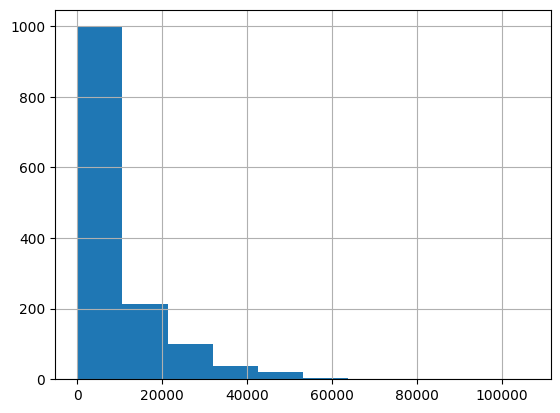

In [12]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('processed/scraped.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
#df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
for index, row in df.iterrows():
    
    text = row['text']
    if type(text) == float:
        n_tokens = len(tokenizer.encode(''))
    else:
        n_tokens = len(tokenizer.encode(text))
    df.at[index, 'n_tokens'] = n_tokens

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

In [14]:
max_tokens = 1000

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]

    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks

In [16]:
shortened = []

# Loop through the dataframe
for row in df.iterrows():
    

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])

    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

<AxesSubplot: >

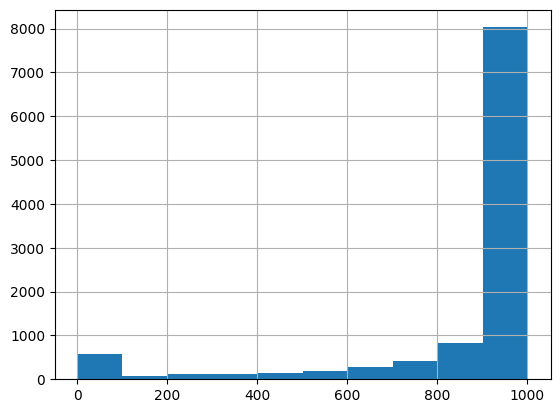

In [29]:
df = pd.DataFrame(shortened, columns = ['text'])

#df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
token_counts = []
for index, row in df.iterrows():
    text = row['text']
    if type(text)==float:
        text = ''
        token_count = len(tokenizer.encode(text))
        token_counts.append(token_count)
    else:
        token_count = len(tokenizer.encode(text))
        token_counts.append(token_count)

# Add the token counts list as a new column in the DataFrame
df['n_tokens'] = token_counts


df.n_tokens.hist()

In [31]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

2023-08-17 19:37:18.456955: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
def get_embeddings(text_list):
    embedding = model.encode(text_list)
    return embedding


In [40]:
df['embeddings'] = get_embeddings(df.text.tolist()).tolist()
df.to_csv('processed/embeddings.csv')
df.head()

/var/folders/8h/d3h46s_d0cq4xl30nshrhl6r0000gn/T/ipykernel_49156/1525183762.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['embeddings'] = get_embeddings(df.text.tolist()).tolist()


,text,n_tokens,embeddings
0,Tensions between Serbia and Kosovo\n\n\n2022–2...,990,"[-0.06889614462852478, 0.05292064696550369, -0..."
1,State Department special envoy for the Balkans...,309,"[-0.01720403879880905, 0.09949538111686707, -0..."
2,The police initially denied the shooting had o...,609,"[0.028161808848381042, 0.11421798169612885, 0...."
3,"Despite the ban, it was reported that Serbian ...",989,"[0.004485389683395624, 0.038330480456352234, -..."
4,Tadić claimed that the proposal would allow Ko...,974,"[-0.04736606776714325, 0.029202641919255257, -..."


In [41]:
import numpy as np
from openai.embeddings_utils import distances_from_embeddings

df=pd.read_csv('processed/embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)

df.head()

,text,n_tokens,embeddings
0,Tensions between Serbia and Kosovo\n\n\n2022–2...,990,"[-0.06889614462852478, 0.05292064696550369, -0..."
1,State Department special envoy for the Balkans...,309,"[-0.01720403879880905, 0.09949538111686707, -0..."
2,The police initially denied the shooting had o...,609,"[0.028161808848381042, 0.11421798169612885, 0...."
3,"Despite the ban, it was reported that Serbian ...",989,"[0.004485389683395624, 0.038330480456352234, -..."
4,Tadić claimed that the proposal would allow Ko...,974,"[-0.04736606776714325, 0.029202641919255257, -..."


In [42]:
def create_context(question, df, max_len=1800, size="ada"):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = get_embeddings(question)
    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():

        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4
        

        # If the context is too long, break
        if cur_len > max_len:
            break

        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    #print(returns)
    return "\n\n###\n\n".join(returns)

In [43]:
import openai
openai.api_type = ""
openai.api_base = ""
openai.api_version = ""
openai.api_key = ''



def answer_question(
    df,
    model="text-davinci-003",
    question="Am I allowed to publish model outputs to Twitter, without a human review?",
    max_len=1800,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=f"Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            engine=model,
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
        return ""

In [49]:
answer_question(df, question="give me list of prime ministers of the world", debug=False)

'Sheikh Hasina, Prime minister (1996–2001)\nLatifur Rahman, Prime minister (2001)\nKhaleda Zia, Prime minister (2001–2006)\nIajuddin Ahmed, Prime minister (2006–2007)\nFazlul Haque, Interim Prime minister (2007)\nFakhruddin Ahmed, Interim Prime minister (2007–2009)\nSheikh Hasina, Prime minister (2009–present)'

In [50]:
answer_question(df, question="briefly explain wikipedia", debug=False)

"Wikipedia is a free online encyclopedia created and edited by volunteers around the world and hosted by the Wikimedia Foundation. It is a multilingual project available in more than 300 languages. Wikipedia's articles provide links to guide the user to related pages with additional information."